<a href="https://colab.research.google.com/github/molybdenum-jo/Customer-Data/blob/main/The_number_of_moviegoers_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dacon_영화 관객수 예측 경진대회
https://dacon.io/competitions/official/235536/data

In [1]:
%ls

 sample_data/  '영화 관객수.zip'


In [2]:
!unzip '영화 관객수.zip'

Archive:  영화 관객수.zip
  inflating: submission.csv          
  inflating: movies_train.csv        
  inflating: movies_test.csv         


# 라이브러리로드


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드

In [4]:
base_path = "."
train = pd.read_csv(f'{base_path}/movies_train.csv', index_col="title")
test = pd.read_csv(f'{base_path}/movies_test.csv', index_col="title")
submission = pd.read_csv(f'{base_path}/submission.csv', index_col="title")

In [5]:
categorical_feature = train.select_dtypes(include="object").columns
train[categorical_feature] = train[categorical_feature].astype("category")
test[categorical_feature] = test[categorical_feature].astype("category")

In [6]:
train= train.fillna(0)
test = test.fillna(0)

In [7]:
train

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
title,,,,,,,,,,,
개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398
내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387
...,...,...,...,...,...,...,...,...,...,...,...
해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091
파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438
살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,0.00,0,123,4,2475


In [8]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train[categorical_feature] = oe.fit_transform(train[categorical_feature])
test[categorical_feature] = oe.transform(test[categorical_feature])

In [10]:
train = train.drop(['dir_prev_bfnum'],axis = 1)
test = test.drop(['dir_prev_bfnum'],axis = 1)

In [12]:
train = train.drop(['director'],axis = 1)
test = test.drop(['director'],axis = 1)

In [13]:
X, y = train.drop(columns="box_off_num"), train["box_off_num"]
X.shape, y.shape

((600, 8), (600,))

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.05, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((570, 8), (30, 8), (570,), (30,))

In [19]:
X_test = test

In [20]:
# torch, nn, optim import 
import torch
import torch.nn as nn
import torch.optim as optim
# PyTorch 모델을 위한 데이터 변환


X_train_t = torch.FloatTensor(X_train.values)
y_train_t = torch.FloatTensor(y_train.values.reshape(-1, 1))
X_valid_t = torch.FloatTensor(X_valid.values)
y_valid_t = torch.FloatTensor(y_valid.values.reshape(-1, 1))
X_test_t = torch.FloatTensor(X_test.values)

# X_train.shape, y_train.shape, X_valid.shape, y_valid.shape
X_train_t.shape, y_train_t.shape, X_valid_t.shape, y_valid_t.shape, X_test_t.shape

(torch.Size([570, 8]),
 torch.Size([570, 1]),
 torch.Size([30, 8]),
 torch.Size([30, 1]),
 torch.Size([243, 8]))

In [21]:
y_train.values.reshape(-1, 1).shape

(570, 1)

In [22]:
X_train_t[0].shape

torch.Size([8])

In [23]:
X_train_t.shape[1]

8

In [24]:
# Multivariate Linear Regression 모델 구현

class MultivariateLinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultivariateLinearRegression, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_size)
        )
    
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x    

# 모델 인스턴스 생성
model = MultivariateLinearRegression(input_size=X_train_t.shape[1], output_size=1)

# 손실 함수 및 최적화 알고리즘 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [25]:
# 모델 학습하기
# epochs
    # 순전파 계산
    # 손실 계산
    # 역전파 계산 및 가중치 갱신
    # 로그 출력
num_epochs = 500
loss_list = []
for epoch in range(num_epochs):
    y_pred = model(X_train_t)
    loss = criterion(y_train_t, y_pred)

    # 역전파
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss_list 시각화나 로그를 확인해 보기 위해 사용
    loss_list.append(loss.item())
    if (epoch + 1) % 50 == 0:
        print(f"epoch:{epoch}, loss:{loss.item()}")

epoch:49, loss:3861078867968.0
epoch:99, loss:3540133347328.0
epoch:149, loss:2999650353152.0
epoch:199, loss:2735423356928.0
epoch:249, loss:2535237615616.0
epoch:299, loss:2399539822592.0
epoch:349, loss:2326989111296.0
epoch:399, loss:2289680777216.0
epoch:449, loss:2265583976448.0
epoch:499, loss:2247899742208.0


<Axes: >

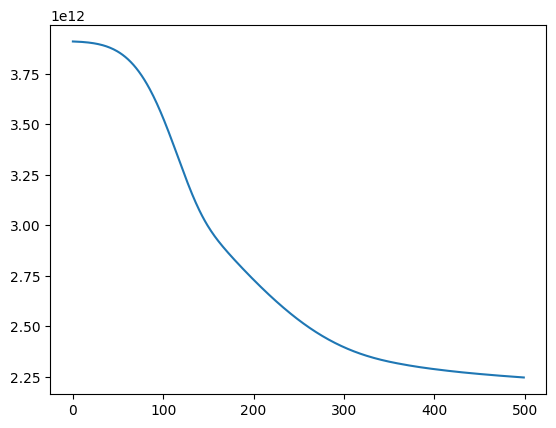

In [26]:
pd.Series(loss_list).plot()

In [27]:
with torch.no_grad():
    y_valid_pred = model(X_valid_t)
    print(f"val_loss : {criterion(y_valid_t, y_valid_pred).item()}")

val_loss : 1757800562688.0


In [28]:
# valid score r2_score

from sklearn.metrics import r2_score

valid_score = r2_score(y_valid_t, y_valid_pred)
valid_score

0.08168049411181866

In [29]:
with torch.no_grad():
    y_predict = model(X_test_t)

In [30]:
y_predict.squeeze().shape

torch.Size([243])

In [31]:
y_predict.squeeze()

tensor([ 1.6446e+06,  1.9261e+06,  2.7463e+06,  2.7902e+06,  2.4382e+06,
         1.1867e+06, -4.6857e+03,  9.3277e+05,  6.2937e+05,  1.8728e+06,
         9.2905e+05,  1.7261e+06,  2.2213e+06,  2.0567e+05,  1.7796e+06,
         3.2373e+06,  6.2296e+05,  1.8264e+06,  1.4275e+06, -3.4926e+03,
         1.7282e+05,  5.1416e+05,  1.0843e+06, -4.4814e+03,  2.6304e+05,
         2.8074e+06, -5.4565e+03,  2.1301e+06,  7.1530e+05,  1.0185e+06,
         1.9410e+06, -3.8543e+03,  2.8683e+04,  1.8516e+06,  8.9590e+04,
         8.2365e+04, -7.7626e+03, -6.4352e+03, -9.2788e+03,  2.1459e+05,
         9.2348e+05, -8.6273e+03, -7.0951e+03, -4.5556e+03,  3.5628e+05,
         2.5195e+06,  2.5471e+05,  1.2166e+06,  4.6073e+05, -6.7911e+03,
         2.6474e+04,  1.3478e+06,  4.8397e+05,  1.4988e+06,  1.8206e+06,
         1.3227e+06, -7.0956e+03,  1.8527e+06,  2.2762e+06,  2.4086e+06,
         2.4737e+06,  2.2943e+06,  9.4588e+05,  4.9572e+03,  1.4043e+06,
         4.8465e+05,  1.8303e+06,  2.7505e+05,  1.0

In [32]:
submission["box_off_num"] = y_predict.squeeze()
submission[:5]

,box_off_num
title,
용서는 없다,1644626.25
아빠가 여자를 좋아해,1926104.50
하모니,2746270.25
의형제,2790204.00
평행 이론,2438206.50


In [33]:
file_name = f"submit_pytorch_{valid_score:.5f}.csv"
file_name

'submit_pytorch_0.08168.csv'

In [34]:
submission.to_csv(file_name)
pd.read_csv(file_name, index_col="title").head(2)

,box_off_num
title,
용서는 없다,1644626.2
아빠가 여자를 좋아해,1926104.5


In [35]:
from google.colab import files

files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>